In [1]:
import wrangle as w 
import os 
from env import get_db_url

import pandas as pd 
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import mitosheet
import folium
from folium.plugins import FastMarkerCluster

In [2]:
train = w.get_exploration_data()

Using cached CSV
The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Yearbuilt converted to age. 



In [ ]:
train

In [9]:
folium_map = folium.Map(location=[34.0522, -118.2437])
folium.Map()

FastMarkerCluster(data=list(zip(train['latitude'].values, train['longitude'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

In [73]:
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# 
# geometry = [Point(xy) for xy in zip(train['longitude'], train['latitude'])]
# crs = {'init': 'epsg:4326'}
# geo_df = gpd.GeoDataFrame(train, crs = crs, geometry = geometry)
# m = folium_map
# 
# folium.Choropleth(geo_data= geo_df,
#     name='choropleth',
#     data=geo_df,
#     columns=['taxrate', 'age'],
#     key_on='feature.id',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Tax Rate and Age %'
# ).add_to(m)

# was hoping to check bivariate relationships this way, but can't get it to work. 
# train = train.drop(columns='geometry')

In [10]:
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode        object
regionidcity                      int64
regionidzip                       int64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
censustractandblock             float64
logerror                        float64
age                               int64
county                           object
taxrate                         float64
structure_cost_per_sqft         float64
land_cost_per_sqft              float64
fiscal_quarter                    int64
dtype: object

In [ ]:
# taxrate and bathroom count have similar distributions, right-skewed.

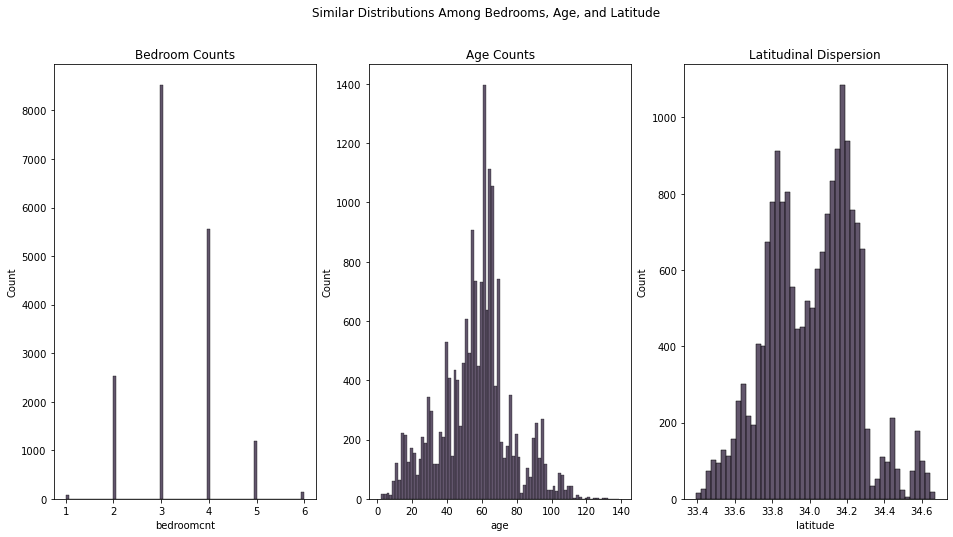

------------------------------------------------------------------------------------------------------------------------------------------


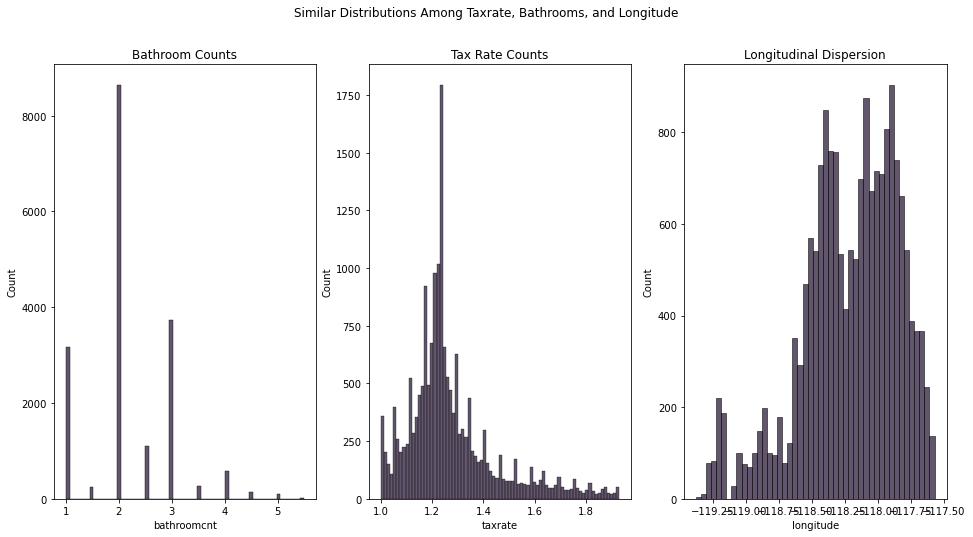


                    Longitude and Latitude increase in frequency in a North-Eastwardly direction.
                         Longitude is like a roughly mirrored version of tax rate and baths. 
            There will be noticeably fewer groupings of properties as one gets closer to the Pacific Ocean.
      
------------------------------------------------------------------------------------------------------------------------------------------


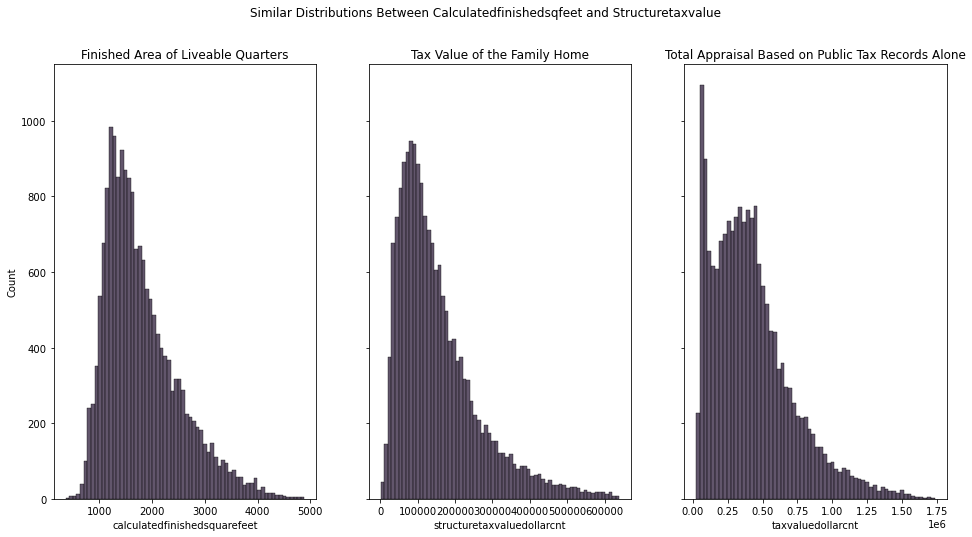


      It comes as a surprise that Area and Structure Tax are NOT direct replicas of one another, 
since calculatedfinishedsquarefeet appears to solely account for the 'living area' of the property,
        (i.e. the garage and lot of land's dimensions are excluded from the square-footage)
--thus the monetary make-up Q('.'Q) of this tax element. Nevertheless, the two variables are nearly identical,
in the shape of their distributions, and so whichever is discovered as holding less value or utility may be disincluded.

        Tax Value's positive-skew is similar to those shown alongside it, but with a distinct spike at the outset.
        Outliers have already been removed from this field, although with lax (permissive) k restriction. 
        Worth looking into. 
      
------------------------------------------------------------------------------------------------------------------------------------------


In [184]:
sns.color_palette("mako", as_cmap=True)
# cannot find a way to format color for all. It makes me sad. 

fig, axes = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('Similar Distributions Among Bedrooms, Age, and Latitude')

sns.histplot(ax=axes[0], x=train.bedroomcnt)
axes[0].set_title('Bedroom Counts')

sns.histplot(ax=axes[1], x=train.age)
axes[1].set_title('Age Counts')

sns.histplot(ax=axes[2], x=train.latitude)
axes[2].set_title('Latitudinal Dispersion')
plt.show()

print('---------------------------------------------------------------\
---------------------------------------------------------------------------')

####################################################################################
####################################################################################
fig, axes = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('Similar Distributions Among Taxrate, Bathrooms, and Longitude')

sns.histplot(ax=axes[0], x=train.bathroomcnt)
axes[0].set_title('Bathroom Counts')

sns.histplot(ax=axes[1], x=train.taxrate)
axes[1].set_title('Tax Rate Counts')

sns.histplot(ax=axes[2], x=train.longitude)
axes[2].set_title('Longitudinal Dispersion')
plt.show()

print('''
                    Longitude and Latitude increase in frequency in a North-Eastwardly direction.
                         Longitude is like a roughly mirrored version of tax rate and baths. 
            There will be noticeably fewer groupings of properties as one gets closer to the Pacific Ocean.
      ''')
      
print('------------------------------------------------------------------\
------------------------------------------------------------------------')
####################################################################################
####################################################################################

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16,8))
fig.suptitle('Similar Distributions Between Calculatedfinishedsqfeet and Structuretaxvalue')

sns.histplot(ax=axes[0], x=train.calculatedfinishedsquarefeet)
axes[0].set_title('Finished Area of Liveable Quarters')

sns.histplot(ax=axes[1], x=train.structuretaxvaluedollarcnt)
axes[1].set_title('Tax Value of the Family Home')

sns.histplot(ax=axes[2], x=train['taxvaluedollarcnt'])
axes[2].set_title('Total Appraisal Based on Public Tax Records Alone')
plt.show()

print('''
      It comes as a surprise that Area and Structure Tax are NOT direct replicas of one another, 
since calculatedfinishedsquarefeet appears to solely account for the 'living area' of the property,
        (i.e. the garage and lot of land's dimensions are excluded from the square-footage)
--thus the monetary make-up Q('.'Q) of this tax element. Nevertheless, the two variables are nearly identical,
in the shape of their distributions, and so whichever is discovered as holding less value or utility may be disincluded.

        Tax Value's positive-skew is similar to those shown alongside it, but with a distinct spike at the outset.
        Outliers have already been removed from this field, although with lax (permissive) k restriction. 
        Worth looking into. 
      ''')

print('---------------------------------------------------------------------\
---------------------------------------------------------------------')
####################################################################################
####################################################################################

In [116]:
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode        object
regionidcity                      int64
regionidzip                       int64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
censustractandblock             float64
logerror                        float64
age                               int64
county                           object
taxrate                         float64
structure_cost_per_sqft         float64
land_cost_per_sqft              float64
fiscal_quarter                    int64
dtype: object

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


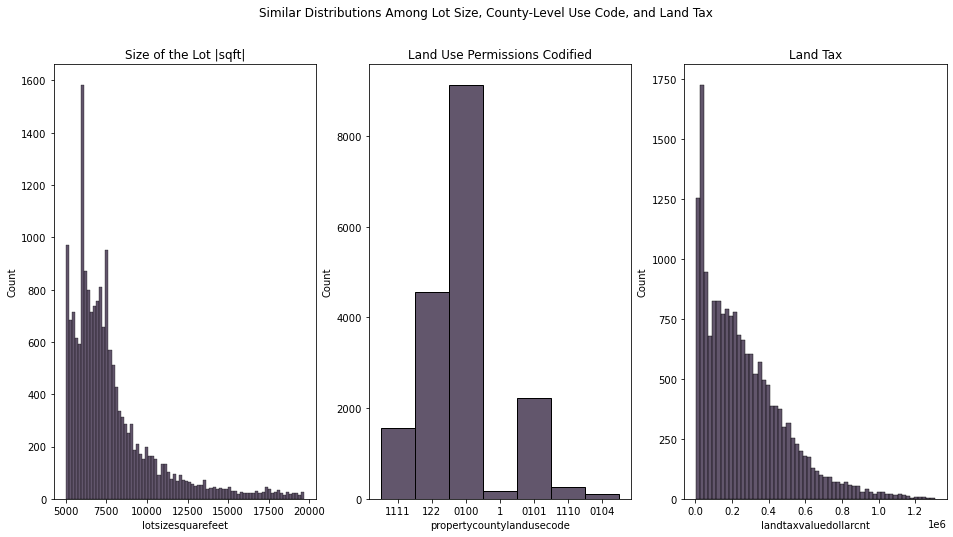

             
                            The vast majority of land is well under 1/5 of an acre
                         With a spike in low costs, and low area. 
                         
                            Each of the four-digit land use codes belong to Los Angeles,
                        hence their abundance of representation.
      
------------------------------------------------------------------------------------------------------------------------------------------


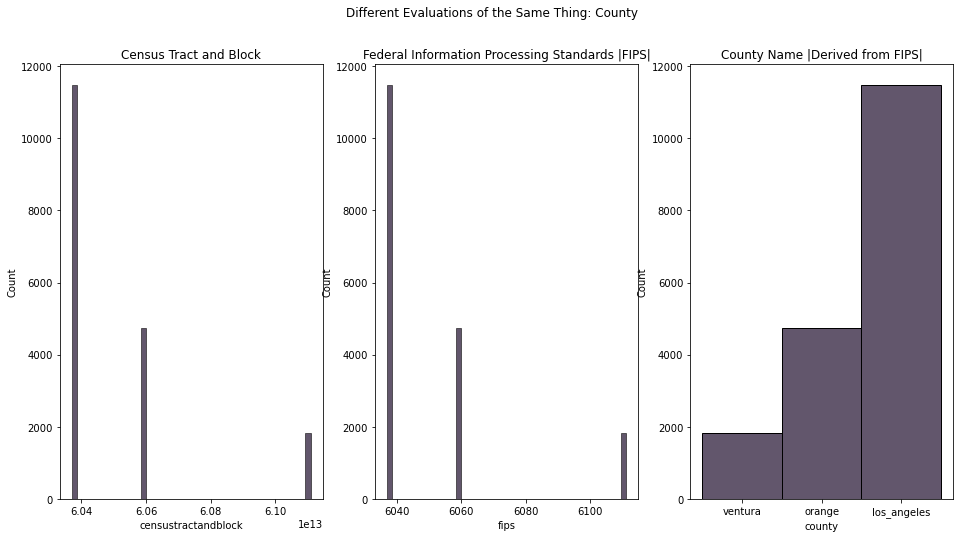


                        I'm still puzzled on how to utilize Census Tract and Block
                            This info likely works well in conjunction with ZIP 
                              and/or Region ID for more narrowly approximating 
                               distances/proximity among and between parcels.
      
------------------------------------------------------------------------------------------------------------------------------------------


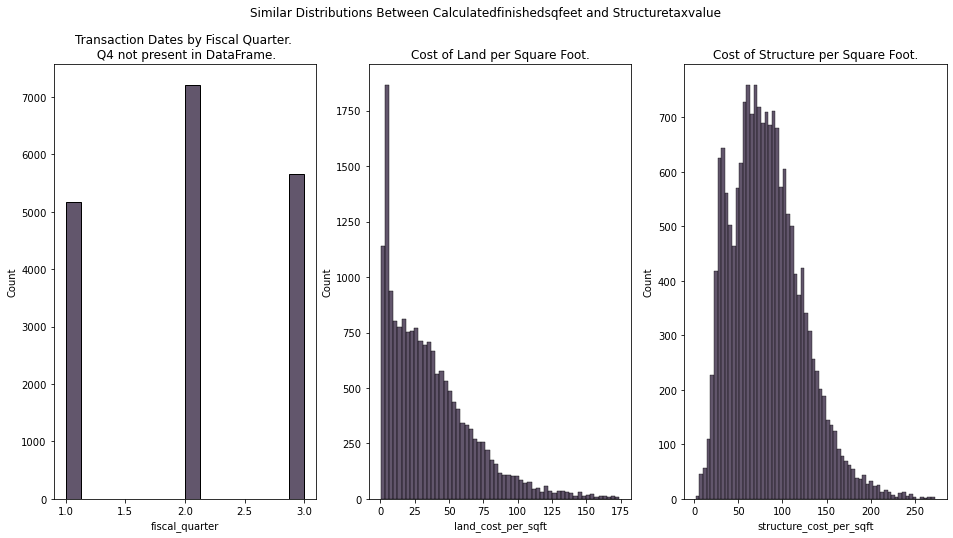


                        Fiscal Quarter bears some visual similarity to bedroom counts.
                        Although this is likely just a coincidence, it does merit some
                        investigation. | Unsurprisingly, structural costs per sq ft 
                        blow land costs out of the water. In the current times, the median
                        cost of a square foot of land in LA, CA, is $1.38. I'll check to see
                        if this lines up with the dataframe. Moreover, the cost to build a home
                        ranges from $100-$400 this year, we can also check if there is consistency
                        with 2017 by examining the margins more closely.
     
      
------------------------------------------------------------------------------------------------------------------------------------------


In [124]:
fig, axes = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('Similar Distributions Among Lot Size, County-Level Use Code, and Land Tax')

sns.histplot(ax=axes[0], x=train.lotsizesquarefeet)
axes[0].set_title('Size of the Lot |sqft|')

sns.histplot(ax=axes[1], x=train.propertycountylandusecode)
axes[1].set_title('Land Use Permissions Codified')

sns.histplot(ax=axes[2], x=train.landtaxvaluedollarcnt)
axes[2].set_title('Land Tax')
plt.show()

print('''             
                            The vast majority of land is well under 1/5 of an acre
                         With a spike in low costs, and low area. 
                         
                            Each of the four-digit land use codes belong to Los Angeles,
                        hence their abundance of representation.
      '''
     )
            
print('---------------------------------------------------------------\
---------------------------------------------------------------------------')

####################################################################################
####################################################################################
fig, axes = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('Different Evaluations of the Same Thing: County')

sns.histplot(ax=axes[0], x=train.censustractandblock)
axes[0].set_title('Census Tract and Block')

sns.histplot(ax=axes[1], x=train.fips)
axes[1].set_title('Federal Information Processing Standards |FIPS|')

sns.histplot(ax=axes[2], x=train.county)
axes[2].set_title('County Name |Derived from FIPS|')
plt.show()

print('''
                        I'm still puzzled on how to utilize Census Tract and Block
                            This info likely works well in conjunction with ZIP 
                              and/or Region ID for more narrowly approximating 
                               distances/proximity among and between parcels.
      ''')
      
print('------------------------------------------------------------------\
------------------------------------------------------------------------')
####################################################################################
####################################################################################

fig, axes = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('Similar Distributions Between Calculatedfinishedsqfeet and Structuretaxvalue')

sns.histplot(ax=axes[0], x=train.fiscal_quarter)
axes[0].set_title('Transaction Dates by Fiscal Quarter. \n Q4 not present in DataFrame.')

sns.histplot(ax=axes[1], x=train.land_cost_per_sqft )
axes[1].set_title('Cost of Land per Square Foot.')

sns.histplot(ax=axes[2], x=train.structure_cost_per_sqft)
axes[2].set_title('Cost of Structure per Square Foot.')
plt.show()

print('''
                        Fiscal Quarter bears some visual similarity to bedroom counts.
                        Although this is likely just a coincidence, it does merit some
                        investigation. | Unsurprisingly, structural costs per sq ft 
                        blow land costs out of the water. In the current times, the median
                        cost of a square foot of land in LA, CA, is $1.38. I'll check to see
                        if this lines up with the dataframe. Moreover, the cost to build a home
                        ranges from $100-$400 this year, we can also check if there is consistency
                        with 2017 by examining the margins more closely.
     
      ''')

print('---------------------------------------------------------------------\
---------------------------------------------------------------------')
####################################################################################
####################################################################################

In [150]:
train['log_abs'] = abs(train['logerror'])

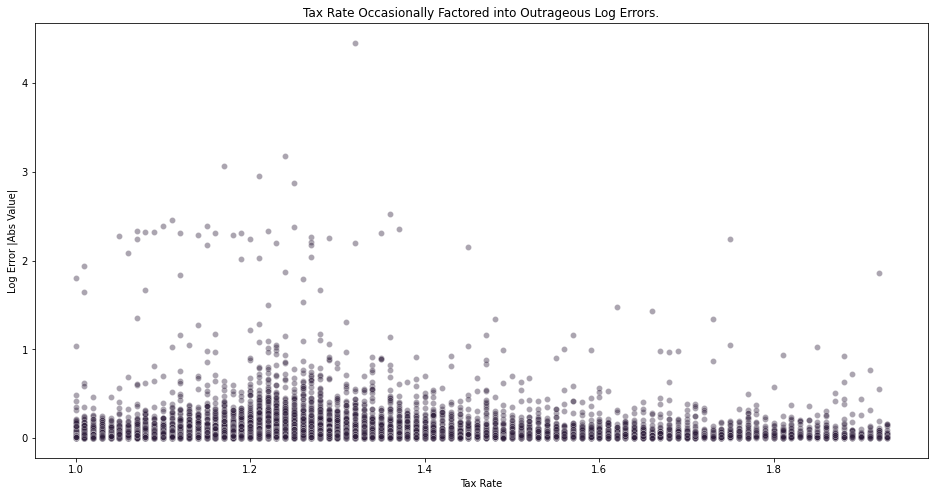

In [187]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='taxrate', y='log_abs', data=train, alpha=.4)
plt.xlabel('Tax Rate')
plt.ylabel('Log Error |Abs Value|')
plt.title('Tax Rate Occasionally Factored into Outrageous Log Errors.')

plt.show()

In [ ]:
train

In [192]:
import mitosheet
mitosheet.sheet(train, analysis_to_replay="id-ouefcifnfm")

MitoWidget(analysis_data_json='{"analysisName": "id-ouefcifnfm", "analysisToReplay": null, "code": [], "stepSu…

In [188]:
import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(train, x='bedroomcnt', y='logerror', color='county')
fig.update_layout(
    title='Interplay Between LogError and Number of Bedrooms', 
    xaxis = dict(
        title='Bedrooms Per Residence', 
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(
        title='Sum of LogError'
    ), 
    barmode='group', 
    paper_bgcolor='#FFFFFF', 
    showlegend=True
)
fig.show(renderer="iframe")

In [190]:
import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(train, x='taxrate', y='logerror', color='county')
fig.update_layout(
    title='Interplay Between LogError and Tax Rate', 
    xaxis = dict(
        title='Tax Rate', 
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(
        title='Sum of LogError'
    ), 
    barmode='group', 
    paper_bgcolor='#FFFFFF', 
    showlegend=True
)
fig.show(renderer="iframe")

import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(train, x='taxrate', y='log_abs', color='county')
fig.update_layout(
    title='Interplay Between LogError and Tax Rate', 
    xaxis = dict(
        title='Tax Rate', 
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(
        title='Sum of LogError (abs)'
    ), 
    barmode='group', 
    paper_bgcolor='#FFFFFF', 
    showlegend=True
)
fig.show(renderer="iframe")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

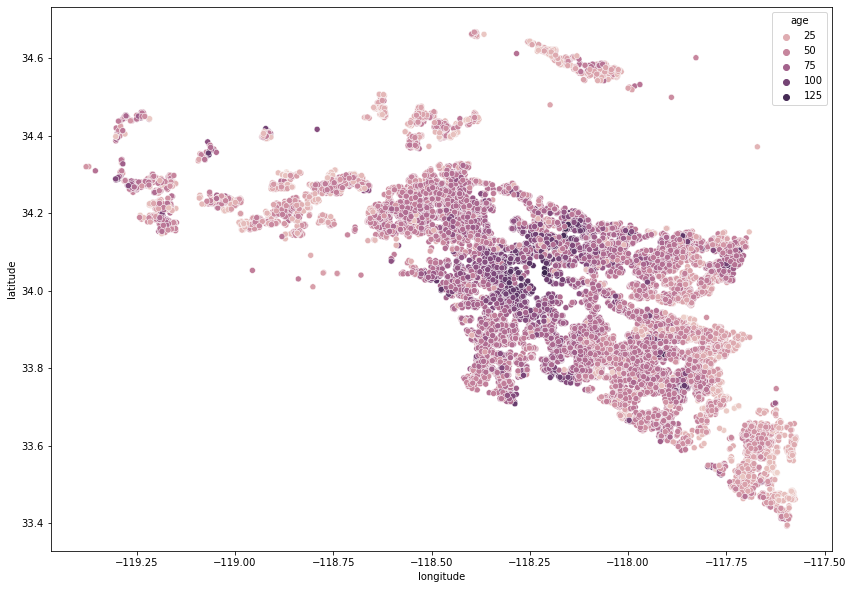

In [47]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=train.age, data=train)

As logerror is the target, first I'll take a cursory glance at its interactions among a few variables, starting with counties. 
#### Does logerror notably differentiate among the three Greater Los Angeles counties in this dataframe: Los Angeles, Orange, and Ventura?

Text(0.5, 1.0, 'County v. Log Error')

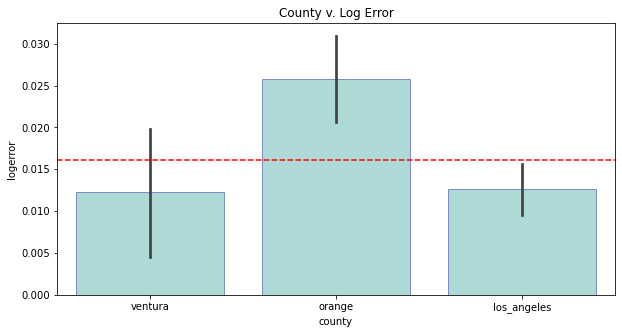

In [14]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(x= train.county, y= train.logerror,  alpha=.4, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County v. Log Error')

Hypothesis Testing - ANOVA       
$H0$ - Differences in logerror among properties by county is insignificant.    
$Ha$ - Logerror differs significantly among Los Ventura, Orange, and Los Angeles

In [15]:
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p

(10.468973966236874, 2.8577230899647764e-05)

In [17]:
null_hypothesis = 'Differences in logerror among properties by county is insignificant.'
alternative_hypothesis = 'Logerror differs significantly among Los Ventura, Orange, and Los Angeles'
if p > α:
    print("We fail to reject the null hypothesis:", null_hypothesis)
else:
    print("We reject the null hypothesis, so", alternative_hypothesis)

We reject the null hypothesis, so Logerror differs significantly among Los Ventura, Orange, and Los Angeles


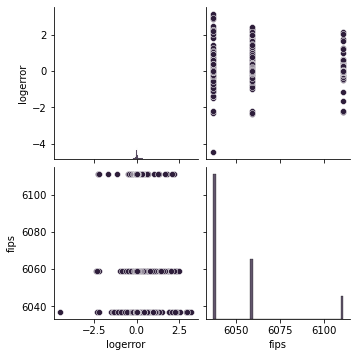

In [20]:
sns.set_palette("mako")
sns.pairplot(train[['logerror', 'fips']])  